## Import ##

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from metrics_f1 import calc_f1_score
from sklearn.metrics import roc_curve,auc

In [3]:
from catboost import CatBoostClassifier

In [4]:
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as ex

In [5]:
#consts

random_seed = 222

#### Данные для работы ####

In [6]:
res_df = pd.read_parquet('Xy_ver0_71.parquet')

In [9]:
res_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14387388 entries, 2022-08-01 to 2023-02-28
Data columns (total 65 columns):
 #   Column               Non-Null Count     Dtype  
---  ------               --------------     -----  
 0   wagnum               14387388 non-null  Int64  
 1   target_month         14387388 non-null  Int64  
 2   target_day           14387388 non-null  Int64  
 3   date                 14387388 non-null  int64  
 4   plan_date            14387388 non-null  int64  
 5   date_kap             14387388 non-null  int64  
 6   date_dep             14387388 non-null  int64  
 7   kod_vrab             14387388 non-null  Int64  
 8   date_pl_rem          14387388 non-null  int64  
 9   id_road_disl         14387388 non-null  Int64  
 10  st_id_dest           14387388 non-null  Int64  
 11  id_road_dest         14387388 non-null  Int64  
 12  st_id_send           14387388 non-null  Int64  
 13  id_road_send         14387388 non-null  Int64  
 14  ost_prob          

In [11]:
res_df.head()

,wagnum,target_month,target_day,date,plan_date,date_kap,date_dep,kod_vrab,date_pl_rem,id_road_disl,...,axl4_l_w_flange,axl4_r_w_flange,axl1_l_w_rim,axl1_r_w_rim,axl2_l_w_rim,axl2_r_w_rim,axl3_l_w_rim,axl3_r_w_rim,axl4_l_w_rim,axl4_r_w_rim
date,,,,,,,,,,,,,,,,,,,,,
2022-08-01,0,0,0,1659312000000000000,1659312000000000000,1375660800000000000,1588723200000000000,0,1683331200000000000,44,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2022-08-01,0,0,0,1659312000000000000,1659312000000000000,1375660800000000000,1588723200000000000,0,1683331200000000000,44,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2022-08-01,1,0,0,1659312000000000000,1659312000000000000,1632873600000000000,1539388800000000000,2,1719792000000000000,30,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2022-08-01,1,0,0,1659312000000000000,1659312000000000000,1632873600000000000,1539388800000000000,2,1719792000000000000,30,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2022-08-01,2,0,0,1659312000000000000,1659312000000000000,1235865600000000000,1633478400000000000,2,1724025600000000000,15,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


#### Preproc ####

In [7]:
#res_df = res_df.fillna(value = res_df.median())
res_df = res_df.sort_index()

In [8]:
res_df = res_df.fillna(value = 0)

##### Сдвиг меток на 1 месяц назад #####

In [9]:
res_df['target_month'] = np.array(res_df.target_month.shift(periods=-1, freq="M"))
res_df['target_day'] = np.array(res_df.target_day.shift(periods=-1, freq="M"))

##### Доп фичи #####

In [12]:
res_df['week_no'] = res_df.index.isocalendar().week
res_df['year'] = res_df.index.isocalendar().year
res_df['month']=res_df.index.month
res_df['is_covid']=(res_df['year']==2020)&(res_df['month']>2)|(res_df['year']==2021)&(res_df['month']==1)
res_df['is_lockdown']=(res_df['year']==2020)&((res_df['month'].isin([3,4])))
res_df['is_covid_peak']=(res_df['year']==2020)&((res_df['month'].isin([4,5,6])))
res_df['is_covid_dis_peak']=(res_df['year']==2021)&((res_df['month'].isin([7,8,9])))
res_df['public_holidays']=(res_df['week_no'].isin([0,1,53]))
res_df['is_crisis']=(res_df['year']==2022)&(res_df['month']>2)|(res_df['year']==2023)

In [31]:
res_df

,wagnum,target_month,target_day,date,plan_date,date_kap,date_dep,kod_vrab,date_pl_rem,id_road_disl,...,ownertype,week_no,year,month,is_covid,is_lockdown,is_covid_peak,is_covid_dis_peak,public_holidays,is_crisis
date,,,,,,,,,,,,,,,,,,,,,
2022-08-01,26318,1,0,1659312000000000000,1659312000000000000,1448409600000000000,1582329600000000000,2,1672531200000000000,38,...,0,31,2022,8,False,False,False,False,False,True
2022-08-01,13886,0,0,1659312000000000000,1659312000000000000,1493164800000000000,1624492800000000000,0,1719187200000000000,28,...,0,31,2022,8,False,False,False,False,False,True
2022-08-01,7506,0,0,1659312000000000000,1659312000000000000,1302566400000000000,1570492800000000000,0,1665187200000000000,25,...,0,31,2022,8,False,False,False,False,False,True
2022-08-01,22343,0,0,1659312000000000000,1659312000000000000,1618012800000000000,1558396800000000000,0,1712707200000000000,16,...,0,31,2022,8,False,False,False,False,False,True
2022-08-01,7104,0,0,1659312000000000000,1659312000000000000,1607040000000000000,1512000000000000000,0,1701648000000000000,42,...,0,31,2022,8,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28,7023,0,0,1677542400000000000,1677542400000000000,1614384000000000000,1521590400000000000,0,1708992000000000000,30,...,0,9,2023,2,False,False,False,False,False,True
2023-02-28,8721,0,0,1677542400000000000,1677542400000000000,1577491200000000000,1486166400000000000,0,1672185600000000000,15,...,0,9,2023,2,False,False,False,False,False,True
2023-02-28,14906,0,0,1677542400000000000,1677542400000000000,1474416000000000000,1588204800000000000,0,1682812800000000000,25,...,0,9,2023,2,False,False,False,False,False,True


##### Split #####

In [10]:
X_train, y_train = (res_df.iloc[:8900000].drop(columns=['target_month','target_day']), 
                res_df.iloc[:8900000][['target_month','target_day']])

In [11]:
X_val, y_val = (res_df.iloc[8900000:12499768].drop(columns=['target_month','target_day']), 
                res_df.iloc[8900000:12499768][['target_month','target_day']])

In [12]:
X_test, y_test = (res_df.iloc[12499768:].drop(columns=['target_month','target_day']), 
                res_df.iloc[12499768:][['target_month','target_day']])

In [31]:
y_train['target_day'].groupby(y_train['target_day']).count()

target_day
0    8839052
1      60948
Name: target_day, dtype: int64

In [51]:
8839063 / 60937

145.05248043060865

In [52]:
y_val['target_day'].groupby(y_val['target_day']).count()

target_day
0    3577545
1      12455
Name: target_day, dtype: int64

In [53]:
3577545 / 12455

287.23765556001604

In [55]:
y_test['target_day'].groupby(y_test['target_day']).count()

target_day
0    1885156
1      12232
Name: target_day, dtype: int64

In [56]:
1885156 / 12232

154.11674296926097

##### Models testing #####

###### Model - target_day ######

In [13]:
cbc1 = CatBoostClassifier(iterations=500, random_seed=random_seed, eval_metric='F1', task_type='GPU', class_weights={0:1, 1:145})
cbc1.fit(X_train, y_train['target_day'], eval_set=(X_val, y_val['target_day']), 
         early_stopping_rounds=100,  
         verbose = 0, plot = True, 
         use_best_model = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

###### Features importances ######

In [14]:
dct_feat = {k:v for k,v in zip(cbc1.feature_names_,cbc1.feature_importances_)}
feats = np.array(sorted({k:v for k,v in dct_feat.items() if (v > 5)}.items(), key = lambda x: x[1], reverse = True))[:,0]
feats

array(['ost_prob', 'date_pl_rem', 'fr_id', 'plan_date', 'date'],
      dtype='<U32')

###### Save model ######

In [15]:
cbc1.save_model('cbc1_87f1_shift_1M_days_12_11_01_56')

In [61]:
#model = CatBoostClassifier()
#model.load_model('cbc1_87f1_shit_1M')

###### Submit res (days) ######

In [16]:
submission_days = cbc1.predict(X_test)

In [17]:
submission_days = pd.DataFrame(submission_days, index = X_test.index, columns = ['target_day'])

In [18]:
submission_days = pd.concat([submission_days, X_test['wagnum']], axis = 1)

In [19]:
submission_days

,target_day,wagnum
date,,
2023-02-01,0,0
2023-02-01,0,0
2023-02-01,0,1
2023-02-01,0,1
2023-02-01,0,2
...,...,...
2023-02-28,0,33974
2023-02-28,0,33975
2023-02-28,0,33975


###### Model - target_month ######

In [67]:
y_train['target_month'].groupby(y_train['target_month']).count()

target_month
0    8428890
1     471110
Name: target_month, dtype: int64

In [70]:
8428890 / 471110

17.891553989514126

In [68]:
y_val['target_day'].groupby(y_val['target_day']).count()

target_day
0    3577545
1      12455
Name: target_day, dtype: int64

In [71]:
3577545 / 12455

287.23765556001604

In [69]:
y_test['target_day'].groupby(y_test['target_day']).count()

target_day
0    1885156
1      12232
Name: target_day, dtype: int64

In [72]:
1885156 / 12232

154.11674296926097

In [74]:
(154 + 287 + 18) / 3

153.0

Нужно менять X train, X test, X val, в идеале, но ладно, пока оставим для следующих гипотез

In [20]:
cbc2 = CatBoostClassifier(iterations=500, random_seed=random_seed, eval_metric='F1', task_type='GPU', class_weights={0:1, 1:145})
cbc2.fit(X_train, y_train['target_month'], eval_set=(X_val, y_val['target_month']), 
         early_stopping_rounds=100,  
         verbose = 0, plot = True, 
         use_best_model = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

###### Save model ######

In [21]:
cbc2.save_model('cbc2_97f1_shift_1M_months_12_11_01_56')

In [ ]:
#model = CatBoostClassifier()
#model.load_model('cbc2_97f1_shit_1M_months')

###### Submit res (months) ######

In [22]:
submission_months = cbc2.predict(X_test,)

In [23]:
submission_months = pd.DataFrame(submission_months, index = X_test.index, columns = ['target_month'])

In [24]:
submission_months = pd.concat([submission_months, X_test['wagnum']], axis = 1)

###### Submit ######

In [25]:
submit = pd.concat([submission_months, submission_days], axis = 1)
submit = submit.loc[:,~submit.columns.duplicated()]

In [26]:
submit.to_csv('good_submit_v03.csv')

In [ ]:
#submit= pd.read_csv('good_submit_v02.csv')

In [191]:
#ress = submit.groupby(by=['wagnum']).max()

In [27]:
ress = submit.groupby(by=['wagnum']).mean()

In [92]:
ress

,target_month,target_day
wagnum,,
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
33972,0.0,0.0
33973,0.0,0.0
33974,0.0,0.0


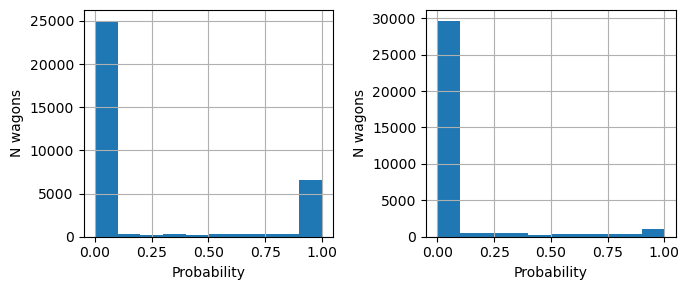

In [28]:
fig,ax= plt.subplots(1,2,figsize=(7,3))
ress.target_month.hist(ax=ax[0], label='target_month')
ress.target_day.hist(ax=ax[1], label='target_day')

ax[0].set_xlabel('Probability')
ax[0].set_ylabel('N wagons')
ax[1].set_xlabel('Probability')
ax[1].set_ylabel('N wagons')

fig.tight_layout()

In [29]:
ress.target_day.unique(), ress.target_month.unique(), 

(array([0.        , 0.67857143, 1.        , 0.42857143, 0.17857143,
        0.03571429, 0.5       , 0.89285714, 0.25      , 0.35714286,
        0.85714286, 0.28571429, 0.57142857, 0.14285714, 0.71428571,
        0.10714286, 0.96428571, 0.46428571, 0.32142857, 0.21428571,
        0.64285714, 0.39285714, 0.60714286, 0.07142857, 0.78571429,
        0.92857143, 0.53571429, 0.75      , 0.82142857]),
 array([0.        , 1.        , 0.10714286, 0.03571429, 0.92857143,
        0.28571429, 0.17857143, 0.75      , 0.67857143, 0.5       ,
        0.21428571, 0.78571429, 0.39285714, 0.71428571, 0.57142857,
        0.60714286, 0.25      , 0.64285714, 0.07142857, 0.89285714,
        0.35714286, 0.46428571, 0.85714286, 0.32142857, 0.42857143,
        0.14285714, 0.96428571, 0.53571429, 0.82142857]))

###### Binarization ######

###### Расчет порогов ######

In [97]:
# 1 вариант
#ress.loc[r_ASS.target_month < 0.25, 'target_month'] = 0
#ress.loc[r_ASS.target_month > 0.25, 'target_month'] = 1

In [106]:
months_1 = cbc2.predict_proba(X_test,)

In [127]:
y_test['target_month'].to_numpy()

array([0, 1, 0, ..., 0, 0, 0], dtype=object)

In [126]:
months_1[:,1]

array([0.92498853, 0.9805882 , 0.01783666, ..., 0.94240473, 0.19110904,
       0.01831711])

In [143]:
fpr, tpr, thresholds = roc_curve(y_score=months_1[:,1], y_true=y_test['target_month'].to_numpy().astype(int),)
roc_auc = auc(fpr, tpr)

In [144]:
roc_auc

0.9364141001827416

(0.0, 1.0)

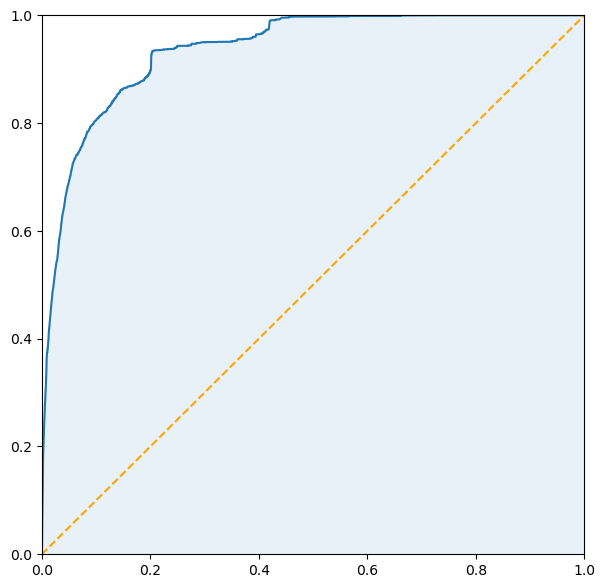

In [141]:
plt.figure(figsize=(7,7))
plt.plot(fpr, tpr)
plt.fill_between(fpr, tpr, color='tab:blue', alpha=0.1)
plt.plot([0,1],[0,1], label = '50%', color = 'orange', linestyle='dashed')
plt.xlim([0,1])
plt.ylim([0,1])

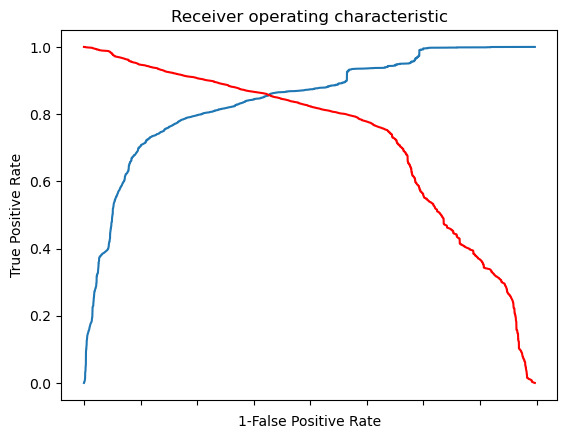

In [150]:
i = np.arange(len(tpr)) # index for df
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
roc.iloc[(roc.tf-0).abs().argsort()[:1]]

# Plot tpr vs 1-fpr
fig, ax = plt.subplots()
plt.plot(roc['tpr'])
plt.plot(roc['1-fpr'], color = 'red');
plt.xlabel('1-False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('Receiver operating characteristic');
ax.set_xticklabels([]);

In [151]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

In [152]:
optimal_threshold

0.4368387951156588

**Для месяцев - optimal_threshold = 0.4368**

Теперь для дней

In [156]:
days_1 = cbc1.predict_proba(X_test)

In [157]:
days_1

array([[0.53089723, 0.46910277],
       [0.17602286, 0.82397714],
       [0.96579642, 0.03420358],
       ...,
       [0.65296312, 0.34703688],
       [0.82353299, 0.17646701],
       [0.97381435, 0.02618565]])

In [158]:
fpr, tpr, thresholds = roc_curve(y_score=days_1[:,1], y_true=y_test['target_day'].to_numpy().astype(int),)
roc_auc = auc(fpr, tpr)

In [159]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

In [160]:
optimal_threshold

0.3847648902547599

Для дней оптимальный = 0.38476

###### Применение порогов ######

In [31]:
ress.loc[ress.target_day < 0.38476, 'target_day'] = 0
ress.loc[ress.target_day >= 0.38476, 'target_day'] = 1

In [32]:
ress.loc[ress.target_month < 0.4368, 'target_month'] = 0
ress.loc[ress.target_month >= 0.4368, 'target_month'] = 1

In [33]:
ress.target_day = ress.target_day.astype(int)
ress.target_month = ress.target_month.astype(int)

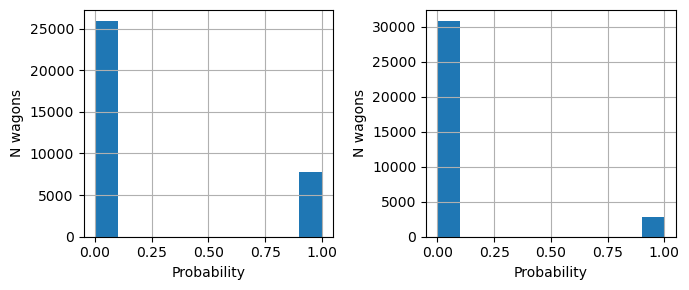

In [34]:
fig,ax= plt.subplots(1,2,figsize=(7,3))
ress.target_month.hist(ax=ax[0], label='target_month')
ress.target_day.hist(ax=ax[1], label='target_day')

ax[0].set_xlabel('Probability')
ax[0].set_ylabel('N wagons')
ax[1].set_xlabel('Probability')
ax[1].set_ylabel('N wagons')

fig.tight_layout()

In [174]:
ress

,target_month,target_day
wagnum,,
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
33972,0,0
33973,0,0
33974,0,0


In [35]:
ress.to_csv('raw_submit_12_11_02_00.csv')

###### Сабмит (для данных уже с порогами) ######

In [36]:
example = pd.read_csv('target/y_predict_submit_example.csv')
example.drop(columns = ['target_month','target_day'], inplace = True)

In [37]:
example.index = example['wagnum']
example.drop(columns = ['wagnum'], inplace = True)

In [38]:
ress = pd.merge(left=example, right=ress, left_index = True, right_index=True, how='left')

In [39]:
ress.fillna(value = 0, inplace = True)

In [40]:
ress.target_day = ress.target_day.astype(int)
ress.target_month = ress.target_month.astype(int)

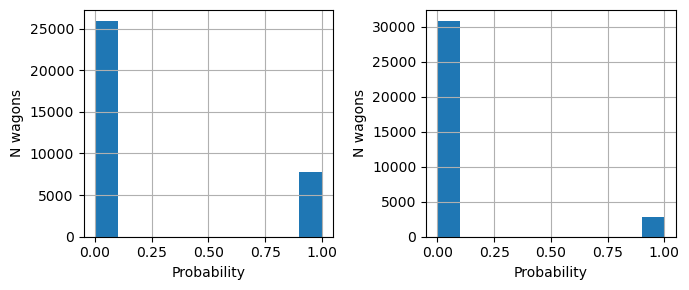

In [41]:
fig,ax= plt.subplots(1,2,figsize=(7,3))
ress.target_month.hist(ax=ax[0], label='target_month')
ress.target_day.hist(ax=ax[1], label='target_day')

ax[0].set_xlabel('Probability')
ax[0].set_ylabel('N wagons')
ax[1].set_xlabel('Probability')
ax[1].set_ylabel('N wagons')

fig.tight_layout()

In [42]:
ress.to_csv('submit_12_11_02_00.csv')